In [1]:
import json
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger
from s4hci.utils.frame_selection import mse_frame_selection, \
    shift_frame_selection

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

# Chenge residual function

In [23]:
from typing import Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.models.normalization import S4FrameNormalization
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.data_handling import save_as_fits


class S4_2(S4):

    @torch.no_grad()
    def compute_residual(
            self,
            account_for_planet_model,
            combine="median",
            num_cpus=8
    ):
        # 1.) Get the current planet signal and subtract it if requested
        if account_for_planet_model:
            planet_model_idx = torch.from_numpy(
                np.arange(self.science_data.shape[0]))
            planet_signal = self.planet_model.forward(planet_model_idx)

            # 3.) Get the current data without the planet
            data_no_planet = self.science_data - \
                planet_signal.squeeze().detach()
            del planet_signal
        else:
            data_no_planet = self.science_data

        # 2.) create a new normalization model which is not biased by the planet
        if account_for_planet_model:
            local_normalization_model = S4FrameNormalization(
                self.data_image_size,
                self.normalization_model.normalization_type)
            local_normalization_model.prepare_normalization(data_no_planet)
        else:
            local_normalization_model = self.normalization_model

        # 3.) normalize the data
        x_norm = local_normalization_model(self.science_data)
        x_no_planet = local_normalization_model(data_no_planet)

        # 4.) reshape everything
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
        science_norm_flatten_no_planet = x_no_planet.view(x_norm.shape[0], -1)

        # 6.) compute the noise estimate
        noise_estimate = self.noise_model(science_norm_flatten_no_planet)

        # 7.) compute the residual sequence
        residual_sequence = science_norm_flatten - noise_estimate
        residual_stack = residual_sequence.view(
            self.science_data.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        # 8.) Compute the unbiased median / mean frame
        residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
        residuals_unbiased = residuals_unbiased.view(
            self.science_data.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        if combine == "mean":
            unbiased_me_frame = np.mean(residuals_unbiased, axis=0)
        else:
            unbiased_me_frame = np.median(residuals_unbiased, axis=0)

        del residuals_unbiased

        # 10.) Compute the residual image
        residual_stack = residual_stack - unbiased_me_frame

        residual_after_fine_tuning = combine_residual_stack(
            residual_stack=residual_stack,
            angles=self.parang,
            combine=combine,
            subtract_temporal_average=False,
            num_cpus=num_cpus)

        return residual_after_fine_tuning, residual_stack

# Load the data

In [2]:
# 2.) Load the dataset
print_message("Loading dataset")
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",  #13_object_final
        psf_template_tag="psf_template", #10_psf
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [3]:
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_0105c.json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [4]:
fake_planet_only = add_fake_planets(
    input_stack=np.zeros_like(science_data),
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

In [5]:
data_with_fake_planet_cut = data_with_fake_planet[::5, 30:-30, 30:-30]
fake_planet_only_cut = fake_planet_only[::5, 30:-30, 30:-30]
science_cut = science_data[::5, 30:-30, 30:-30]
angles_cut = raw_angles[::5]

# Filter in time

In [6]:
from scipy.ndimage import gaussian_filter1d

In [7]:
filtered1 = gaussian_filter1d(data_with_fake_planet_cut, sigma=200, axis=0)
filtered2 = gaussian_filter1d(data_with_fake_planet_cut, sigma=2000, axis=0)

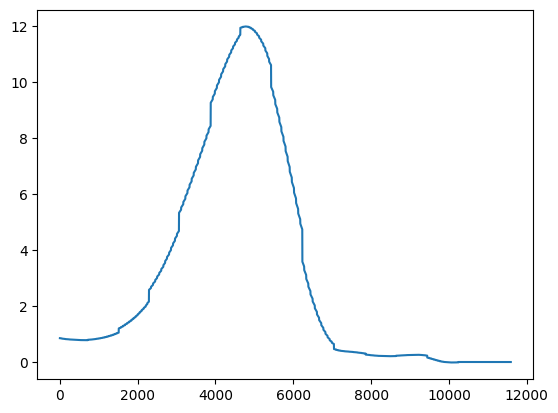

In [8]:
plt.plot(fake_planet_only_cut[:, 40, 20])

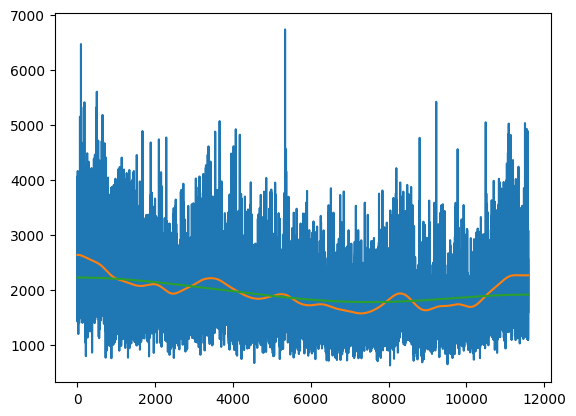

In [9]:
plt.plot(data_with_fake_planet_cut[:, 20, 30])
plt.plot(filtered1[:, 20, 30])
plt.plot(filtered2[:, 20, 30])

In [10]:
cube_freq_removed = data_with_fake_planet_cut - filtered1 + filtered2

# Build S4 models

In [24]:
s4_model_filtered = S4_2(
    science_data=cube_freq_removed,
    parang=angles_cut,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/filter_in_time",
    convolve=True,
    verbose=True)

s4_model_filtered.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:34<00:00, 34.27it/s]

[DONE]
[DONE]
[DONE]


In [25]:
s4_model_raw = S4(
    science_data=data_with_fake_planet_cut,
    parang=angles_cut,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/filter_in_time",
    convolve=True,
    verbose=True)

s4_model_raw.find_closed_form_noise_model(fp_precision="float32")

S4 model: finding closed form noise model ... S4 Noise: fitting noise model ... Fitting ... 

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3249/3249 [01:36<00:00, 33.54it/s]

[DONE]
[DONE]
[DONE]


# Compute the classical residuals

In [26]:
import torch

In [27]:
model = s4_model_filtered
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
residual_filtered, residual_filtered_stack = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

In [29]:
model = s4_model_raw
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
residual_raw = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


# Compute the residuals on the data with no planet

In [16]:
model = s4_model_filtered
model.science_data = torch.from_numpy(science_cut).float()
residual_filtered_np = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


In [17]:
model = s4_model_raw
model.science_data = torch.from_numpy(science_cut).float()
residual_raw_np = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


# Plot the results

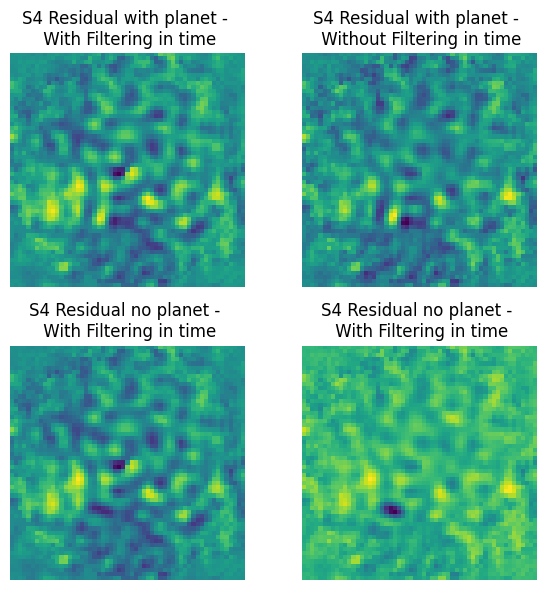

In [18]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))

ax1.imshow(residual_filtered, origin="lower")#, vmin=-0.02, vmax=0.02)
ax2.imshow(residual_raw, origin="lower")#, vmin=-0.02, vmax=0.02)
ax3.imshow(residual_filtered_np, origin="lower")#, vmin=-0.02, vmax=0.02)
ax4.imshow(residual_raw_np, origin="lower")#, vmin=-0.02, vmax=0.02)

ax1.axis("off")
ax1.set_title("S4 Residual with planet - \n With Filtering in time")
ax2.axis("off")
ax2.set_title("S4 Residual with planet - \n Without Filtering in time")
ax3.axis("off")
ax3.set_title("S4 Residual no planet - \n With Filtering in time")
ax4.axis("off")
ax4.set_title("S4 Residual no planet - \n With Filtering in time")
plt.tight_layout()

# Look at some weights

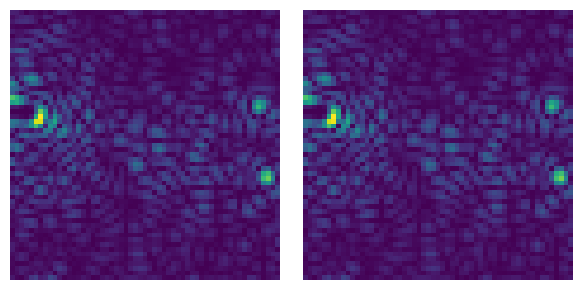

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

ax1.imshow(s4_model_filtered.noise_model.betas[1200].view(57, 57).abs().detach())
ax2.imshow(s4_model_raw.noise_model.betas[1200].view(57, 57).abs().detach())

ax1.axis("off")
ax2.axis("off")
plt.tight_layout()

# Combine with PCA

In [31]:
from s4hci.utils.pca import pca_psf_subtraction_gpu

In [43]:
pca_residual = pca_psf_subtraction_gpu(
    residual_filtered_stack, 
    angles_cut, 
    np.arange(200), 
    device=0,
    approx_svd=50*50)

In [44]:
pca_residual.shape

(200, 57, 57)

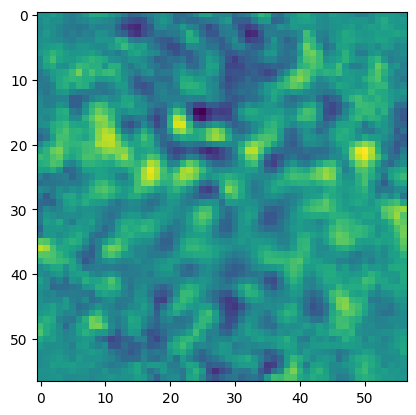

In [54]:
plt.imshow(pca_residual[10])